In [1]:
import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from astropy import units as u

## Spatially resolved SF law for EDGE.  

## x-axis: 7" CO intensity from the smoothed mask.  

## y-axis: Halpha flux from flux_elines smoothed to 7".

In [2]:
hafile = '../img_califa/edge.pipe3d.hdf5'
cofile = '../img_comom/edge.comom_smo7.hdf5'

In [3]:
cotab=Table.read(cofile, path='smo')
hatab=Table.read(hafile, path='flux_elines_sm')
jointbl = join(cotab,hatab)
print(jointbl.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_vel_[SII]6717', 'e_vel

['ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'ARP220', 'NGC2623', 'NGC2623', 'NGC2623', 'NGC2623', 'NGC2623', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC5218', 'NGC6361', 'NGC6361', 'NGC6361', 'NGC6361']


/opt/conda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/opt/conda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


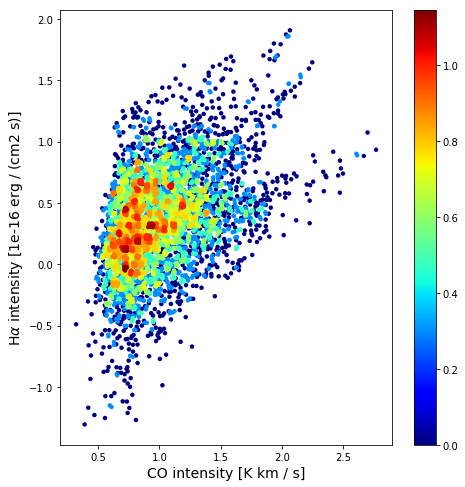

In [4]:
# Apply a 3-sigma cut to both axes
det = (jointbl['mom0']>3*jointbl['emom0']) & (
    jointbl['flux_Halpha']>3*jointbl['e_flux_Halpha'])
codata = jointbl['mom0'][det]
hadata = jointbl['flux_Halpha'][det]
x = np.log10(codata)
y = np.log10(hadata)

# Print names of galaxies showing high CO but low Halpha
odd = (jointbl['mom0']>100) & (jointbl['flux_Halpha']<10)
print(list(jointbl['Name'][odd]))

# Histogram the data
# https://stackoverflow.com/questions/49662964/density-scatter-plot-for-huge-dataset-in-matplotlib
bins = [100,100]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Get the bin value for each point
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x, y, c=np.log10(z), s=20, edgecolor='', cmap=cm)
plt.xlabel('CO intensity ['+str(codata.unit)+']',fontsize=14)
plt.ylabel(r'H$\alpha$ intensity ['+str(hadata.unit)+']',fontsize=14)
ax.set_aspect('equal')
plt.colorbar(sc)

In [5]:
# Convert Halpha intensity to A_V-corrected SFR surface density
def sfr_ha(flux_ha, flux_hb):
    # Extinction curve from Cardelli+(1989).
    K_Ha = 2.53
    K_Hb = 3.61
    # Eq(1) from Catalan-Torrecilla+(2015). 
    A_Ha = K_Ha/(-0.4*(K_Ha-K_Hb)) * np.log10((flux_ha/flux_hb)/2.86)
    A_Ha[A_Ha < 0] = 0.
    flux_ha_cor = flux_ha * 10**(0.4*A_Ha)
    # line flux is actually flux per arcsec2
    sterad = (u.sr/u.arcsec**2).decompose()   # 206265^2
    sb_ha  = flux_ha_cor * sterad   # flux per steradian
    lsd_ha = 4*np.pi * sb_ha
    # Eq(4) from Catalan-Torrecilla+(2015).
    lumcon = 5.5e-42 * (u.solMass/u.yr) / (u.erg/u.s)
    sigsfr = (lumcon * lsd_ha).to(u.solMass/(u.pc**2*u.Gyr))
    return sigsfr

In [6]:
# Convert CO intensity to H2(+He) surface density
def msd_co(sb_co, alphaco=4.3):
    convfac = alphaco * (u.solMass/u.pc**2) / (u.K*u.km/u.s)
    sig_mol = (convfac*sb_co).to(u.solMass/u.pc**2)
    return sig_mol

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/opt/conda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/opt/conda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


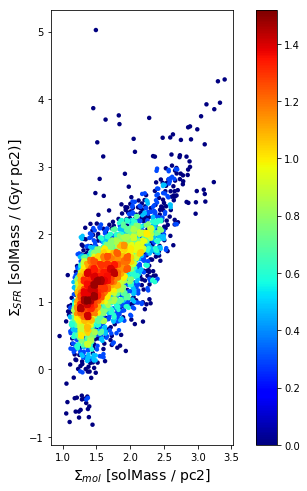

In [7]:
# Operate on the detections
sig_mol = msd_co(jointbl['mom0'][det])
sig_sfr = sfr_ha(jointbl['flux_Halpha'][det],jointbl['flux_Hbeta'][det])

# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_mol)) & (~np.isnan(sig_sfr)) & (sig_mol>0) & (sig_sfr>0)
x = np.log10(sig_mol[not_nan].value)
y = np.log10(sig_sfr[not_nan].value)

# Histogram the data
# https://stackoverflow.com/questions/49662964/density-scatter-plot-for-huge-dataset-in-matplotlib
bins = [50, 100]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Get the bin value for each point
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x, y, c=np.log10(z), s=20, edgecolor='', cmap=cm)
plt.xlabel(r'$\Sigma_{mol}$ ['+str(sig_mol.unit)+']',fontsize=14)
plt.ylabel(r'$\Sigma_{SFR}$ ['+str(sig_sfr.unit)+']',fontsize=14)
ax.set_aspect('equal')
plt.colorbar(sc)